In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Etap I - EDA

Zbiór danych zawiera 8265 słów występujących w księgach religijnych przygotowanych jako mini-korpus tych ksiąg (gdyż nie są to wszystkie słowa, a wybrane przez twórców). Większość świętych tekstów w tym zbiorze danych zebrano z projektu Gutenberg. W tym etapie zajmiemy się analizą tych słów i ksiąg, zawierających je.

## Wczytanie zbioru

In [0]:
data  = pd.read_csv('/content/drive/My Drive/AllBooks_baseline_DTM_Labelled.csv')

In [0]:
data.head()

,Unnamed: 0,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,convict,diadem,rushed,saliva,revelation,indirectly,open,distortions,expecteth,perishing,rage,unbridled,looketh,washed,nursingmother,caper,prosperous,lightmindedness,imprisonment,maghavan,supported,distinctions,lambs,illumination,mercury,partakers,tell,build,neither,soft,...,budding,enjoyer,needs,sittest,eclipsed,engagement,exuberant,abandons,well,cheerfulness,hatest,state,stained,production,whitened,revered,developed,regarded,enactments,aromatical,admireth,foothold,shots,turner,inversion,lifeless,postponement,stout,taketh,kettle,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,Buddhism_Ch1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Buddhism_Ch2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Buddhism_Ch3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Buddhism_Ch4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Buddhism_Ch5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data.shape # bardzo dużo kolumn

(590, 8267)

In [0]:
data.isnull().values.any() #sprawdzenie czy są braki

False

Zebrane dane zawierają o wiele więcej kolumn niż wierszy, a przygotowana ramka danych nie ma brakujących wartości.


### Stworzenie kolumnny z nazwą księgi -  tylko do EDA

Aby móc rozpoznawać księgi oraz je jakoś przeanalizować, zdecydowaliśmy się na stworzenie kolumny z nazwą księgi i pogrupowanie rozdziałów z ramki danych na całe księgi. W ten sposób przyjrzymy się temu o czym są całe księgi.


In [0]:
data['label']=data['Unnamed: 0'].str.split('_',expand=True)[0] #do jakiej księgi należy dany rozdział

In [0]:
np.unique(data['label']) 

array(['BookOfEccleasiasticus', 'BookOfEcclesiastes', 'BookOfProverb',
       'BookOfWisdom', 'Buddhism', 'TaoTeChing', 'Upanishad', 'YogaSutra'],
      dtype=object)

Mamy 8 ksiąg - tak jak w było przedstawione w opisie zbioru, na początek zapoznajmy się z tym, jakie to są księgi.<br>
## Tłumaczenia nazw i krótkie opisy ksiąg:
* Book of Eccleasiasticus - Mądrość Syracha - jedna z ksiąg deuterookanonicznych Starego Testamentu (czyli takich, które są w Biblii chrześcijańskiej, ale nie w hebrajskiej. Napisana ok. 190 r.p.n.e. w Jerozolimie
* Book Of Ecclesiastes - Księga Koheleta - znajduje sie w obu Bibliach. Datowanie księgi nie jest pewne, choć są znaki, aby określać je na III w.p.n.e.
* Book of Proverb - Księga Przysłów - również w obu Bibliach, jest pracą zbiorową złożoną z różnych tekstów przez nieznanego autora ok. V w.p.n.e.
* Book of Wisdom - Księga Mądrości - napisana prawdopodobnie w Aleksandrii (Egipt) - datowana na ok. 50 r.p.n.e.
* Buddhism - oczywiście nazwa religii dalekiego wschodu - buddyzmu, który najczęściej jest wyznawany w kraja półwyspu indochińskiego, Malezji, Chinach i Monoglii.
* Tao Te Ching - także: Lao Tsu - chińska księga najprawdopodobniej napisana w 6 wieku p.n.e. przez mędrca Laozi. Uważana jest za podstawowe dzieło taoizmu - jedną z najpopularniejszych chińskich religii. Badacze twierdzą także, że miała ona wpływ także na kształtowanie filozofii buddystów.
* Upanishads - upaniszady - teksty (w liczbie ponad 200) religii hinduizmu należące do wedyjskiego objawienia o treści religijno - filozoficznej. Jedne z późniejszych tekstów należących do Wed (świętych ksiąg hinduizmu), napisane w VIII - III w.p.n.e. Są do dziś wykorzystywane nawet w naszej kulturze wśród osób praktykujących medytację.
* Yoga Sutra - jogasutry (hinduizm) - najstarszy tekst klasycznej Jogi (w znaczeniu systemu filozofii indyjskiej, uznającego autorytet Wed), składający się ze 195 sutr - zwięzłych sentencji. Według hinduskich tradycji, ich autorem był żyjący w II w.p.n.e. Patañjāli.


Przejdźmy do analizowania ksiąg i ich słów.

## Najczęściej występujące słowa ogółem


In [0]:
words = pd.DataFrame(data.drop(['Unnamed: 0', 'label'], axis=1).sum())
words_sorted = words.sort_values(by=0, ascending=False)
words_sorted.head(10) #10 najczęściej używanych słów ogółem

,0
shall,1168
man,846
thy,645
one,473
things,468
thou,449
god,385
life,357
hath,334
spiritual,309


Najczęściej występuje słowo $shall$.

Przyjrzyjmy się wykresowi wystąpień słów.

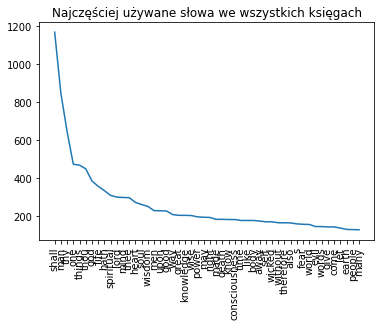

In [0]:
plt.plot(words_sorted.head(50))
plt.xticks(rotation = 90)
plt.title('Najczęściej używane słowa we wszystkich księgach')
plt.show()

Jak widzimy po tabeli i wykresie dwa-trzy słowa się wyróżniają a potem mamy wyraźny spadek. Większość słów nie przekracza nawet 200 wystąpień.

## Liczba użyć danego słowa w każdej z ksiąg


Przygotowaliśmy ramkę danych z liczbami wystapień słów dla każdej księgi. Można ją zobaczyć poniżej.

In [0]:
grouped_data = data.groupby(['label']).sum()
grouped_data[words_sorted.index.values]

,shall,man,thy,one,things,thou,god,life,hath,spiritual,lord,mind,thee,heart,soul,wisdom,men,upon,good,way,great,knowledge,wise,power,may,right,made,death,know,consciousness,time,like,body,away,self,wicked,without,therefore,also,s,...,directing,breathed,inductive,consolation,flits,threedimensional,sedition,xii,goad,disentangled,presuming,instanced,cain,irregularity,despoil,impudently,widely,inaccurate,sannyasin,agent,approacheth,represents,beautifully,satan,humbly,enlargeth,aids,lean,inhabit,types,vividly,separates,saveth,insects,toughness,inert,allconscious,principal,diversities,occurs
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BookOfEccleasiasticus,508,232,330,77,120,230,193,65,189,0,152,20,170,96,80,97,82,115,95,26,58,28,58,36,35,11,64,45,17,0,61,56,11,54,1,42,30,14,35,29,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
BookOfEcclesiastes,89,71,43,19,46,26,46,16,46,0,1,11,6,27,9,26,22,12,22,3,14,5,22,7,6,3,14,8,16,0,42,4,1,8,0,11,3,8,31,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BookOfProverb,389,176,165,23,45,93,19,37,65,0,85,15,59,64,47,53,32,27,46,56,10,26,71,4,17,18,13,19,6,0,7,25,1,29,0,92,17,7,17,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
BookOfWisdom,120,38,86,20,89,61,67,26,32,0,28,3,30,7,12,38,30,37,26,11,17,10,5,22,13,4,35,15,19,0,21,12,5,18,0,25,21,26,18,9,...,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Buddhism,0,11,0,75,8,0,0,22,0,0,9,71,0,4,0,0,0,0,5,55,6,33,0,0,12,128,26,13,19,47,1,4,73,26,6,0,16,4,2,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TaoTeChing,17,16,1,51,56,1,1,16,0,2,4,9,0,0,0,4,45,1,16,24,42,11,1,3,23,7,8,17,31,0,4,24,4,10,3,0,32,40,10,23,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Upanishad,10,63,15,100,16,28,31,27,0,7,12,71,29,31,19,14,9,8,11,6,23,51,30,12,22,6,6,56,50,13,7,22,30,14,79,0,22,32,23,19,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
YogaSutra,35,239,5,108,88,10,28,148,2,300,9,98,3,43,94,19,9,28,6,27,34,40,16,112,66,16,17,10,24,122,34,30,52,15,81,0,24,34,28,47,...,0,0,1,1,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,1,1,1,0,0,1


### Sprawdzenie czy istnieje kolumna z samymi zerami (słowo nie występujące nigdzie)


In [0]:
check = grouped_data==0
check.all().any() 

False

Tak więc twórcy danych zdecydowali się na wykorzystanie tylko tych słów, które występują w co najmniej jednej księdze. Wspominając o tym, sprawdźmy ile rzeczywiście słów występuje tylko w jednej księdze.

## Najczęściej używane słowo dla każdej księgi


Skoro wiemy jakie słowa są najpopularniejsze ogólnie to przyjrzyjmy się jak to przekłada się na oddzielne księgi.

In [0]:
pd.DataFrame(grouped_data.idxmax(axis=1), columns = ['Najczęściej używany wyraz:'])

,Najczęściej używany wyraz:
label,
BookOfEccleasiasticus,shall
BookOfEcclesiastes,shall
BookOfProverb,shall
BookOfWisdom,shall
Buddhism,right
TaoTeChing,tao
Upanishad,one
YogaSutra,spiritual


W czterech księgach powtórzyło się słowo $shall$, natomiast słowa z księgi Buddyjskiej i TaoTeChing nie znalazły się w 10 najpopularnijszych słowach dla ogółu, więc możlwie, że przejawiają się one w większośći właśnie tam (tao szczególnie).

## Ramka danych ze słowami, które występują tylko w jednej księdze


Znamy już najpopularniejsze słowa to teraz przyjrzymy się unikatowym wyrazom, które skupiają się tylko w danej księdze. 

In [0]:
unique_words = grouped_data==grouped_data.sum()
unique_words = grouped_data.columns[unique_words.any()]



In [0]:
unique_words_dataframe = pd.DataFrame()
for word in unique_words:
  idx = grouped_data[grouped_data[word]!=0].index[0]
  unique_words_dataframe = unique_words_dataframe.append({'word':word, 'book':idx}, ignore_index=True)

In [0]:
unique_words_dataframe

,book,word
0,BookOfProverb,foolishness
1,BookOfEccleasiasticus,takest
2,Buddhism,feelings
3,Upanishad,vaivaswata
4,YogaSutra,matrix
...,...,...
4883,BookOfWisdom,erred
4884,YogaSutra,modern
4885,BookOfEccleasiasticus,reigned
4886,BookOfEccleasiasticus,sparingly


In [0]:
#z ciekawości sprawdziliśmy, czy tao występuje tylko w taoistycznej księdze
unique_words_dataframe[unique_words_dataframe.word == 'tao']

,book,word
1786,TaoTeChing,tao


4888 słowa są unikatowe, czyli ponad 50% słów wystepuje tylko w jednej z ośmiu ksiąg - może być przydatne przy klasteryzacji.<br>Sprawdźmy też, ile słów jest charakterystycznych dla danej księgi - to znaczy ponad 90% wystąpień zawiera się w jednym tekście oraz ile wystąpiło w każdej z ksiąg (zauważmy, że mogą wystąpić słowa w obydwu grupach).






In [0]:
print(f'Odsetek słów, których ponad 90% wystąpień jest w dokładnie jednej księdze: {round(100*np.mean(grouped_data.max(axis = 0)/grouped_data.sum() >0.9), 2)}%')
print(f'Odsetek słów, które wystąpiły w każdej z ksiąg: {round(100*np.mean(np.mean((grouped_data>0)) == 1), 2)}%')

Odsetek słów, których ponad 90% wystąpień jest w dokładnie jednej księdze: 59.63%
Odsetek słów, które wystąpiły w każdej z ksiąg: 1.29%


Mamy prawie 60% słów, których 90% wystąpień skupiona jest w jednej księdze.

Przyjrzyjmy się temu 1.29% słów we wszystkich księgach.

## Wspólne słowa dla wszystkich ksiąg

In [0]:
common_words = np.array(grouped_data.columns[np.where(np.mean((grouped_data>0)) == 1)])
common_words

array(['neither', 'let', 'great', 'reward', 'think', 'full', 'thing',
       'good', 'day', 'whole', 'body', 'still', 'said', 'follow',
       'brought', 'might', 'strong', 'become', 'fruit', 'long', 'death',
       'mind', 'us', 'time', 'turn', 'done', 'cast', 'seeing', 'evil',
       'never', 'therefore', 'come', 'away', 'go', 'things', 'age',
       'always', 'truth', 'tree', 'whose', 'give', 'knowledge', 'seen',
       'speech', 'end', 'called', 'sorrow', 'old', 'without', 'may',
       'back', 'name', 'forth', 'light', 'others', 'earth', 'wind',
       'filled', 'able', 'head', 'cause', 'also', 'say', 'strength',
       'place', 'world', 'another', 'peace', 'know', 'heard', 'nothing',
       'alone', 'far', 'together', 'person', 'speak', 'make', 'among',
       'thought', 'yet', 'right', 'life', 'would', 'water', 'given',
       'part', 'known', 'return', 'even', 'man', 'like', 'desire',
       'subject', 'one', 'delight', 'words', 's', 'sweet', 'years',
       'bring', 'lord', 'w

In [0]:
common_words.size

107

Mamy 107 wspólnych słów, jak było powiedziane wyżej - jest to 1.29% wszystkich słów. Przyjrzyjmy się, jakie części mowy pojawiają się najczęściej - sugestią byłyby orzeczenia/czasowniki, gdyż to słowa ogólne, które najbardziej powinny nie być bezpośrednio do jednej z ksiąg. Przekonajmy się.

Uwaga: Można się przyjrzeć i zobaczyć, że kilka słów się powtarza, jednak w innej formie gramatycznej. W tym przypadku zastosujemy lematyzację, gdyż do sprawdzenia części mowy, nie stracimy cennych informacji.

In [0]:
def lemmatization(data):
  '''
  Podajemy numpy array list a zwracana jest numpy array list unikatowych słów po lematyzacji
  '''
  lem = WordNetLemmatizer()
  A = []
  for i in data.tolist():
    a = lem.lemmatize(i)
    a = lem.lemmatize(a, 'a')
    a = lem.lemmatize(a, 'v')
    A.append(a)
  x = np.array(A)
  A = np.unique(x)
  return A

In [0]:
A = lemmatization(common_words)
A.size

98

Mamy mniej o 9 słów. (Lemmatyzacja to experyment, możliwe, że nadal niektóre słowa nie zmieniły formy)

In [0]:
tag_words = nltk.pos_tag(A.tolist())
tag_words

[('able', 'JJ'),
 ('age', 'NN'),
 ('alone', 'RB'),
 ('also', 'RB'),
 ('always', 'RB'),
 ('among', 'IN'),
 ('another', 'DT'),
 ('away', 'RB'),
 ('back', 'RB'),
 ('become', 'JJ'),
 ('body', 'NN'),
 ('bring', 'VBG'),
 ('call', 'JJ'),
 ('cast', 'NN'),
 ('cause', 'NN'),
 ('come', 'VBN'),
 ('day', 'NN'),
 ('death', 'NN'),
 ('delight', 'NN'),
 ('desire', 'NN'),
 ('do', 'VBP'),
 ('earth', 'JJ'),
 ('end', 'VB'),
 ('even', 'RB'),
 ('evil', 'JJ'),
 ('far', 'RB'),
 ('fill', 'RB'),
 ('follow', 'JJ'),
 ('forth', 'NN'),
 ('fruit', 'NN'),
 ('full', 'JJ'),
 ('give', 'NN'),
 ('go', 'VB'),
 ('good', 'JJ'),
 ('great', 'JJ'),
 ('head', 'NN'),
 ('hear', 'VBP'),
 ('know', 'VBP'),
 ('knowledge', 'NN'),
 ('let', 'JJ'),
 ('life', 'NN'),
 ('light', 'NN'),
 ('like', 'IN'),
 ('long', 'JJ'),
 ('lord', 'NN'),
 ('make', 'VBP'),
 ('man', 'NN'),
 ('may', 'MD'),
 ('might', 'MD'),
 ('mind', 'VB'),
 ('name', 'NN'),
 ('neither', 'CC'),
 ('never', 'RB'),
 ('nothing', 'NN'),
 ('old', 'JJ'),
 ('one', 'CD'),
 ('others', 'NNS')

Policzmy teraz jakiej częsci mowy jest najwięcej.

In [0]:
POS_list = []
for i in tag_words:
  POS_list.append(i[1])

In [0]:
Counter(POS_list).most_common()

[('NN', 37),
 ('JJ', 19),
 ('RB', 14),
 ('VBP', 9),
 ('IN', 4),
 ('VB', 3),
 ('MD', 3),
 ('VBN', 2),
 ('NNS', 2),
 ('DT', 1),
 ('VBG', 1),
 ('CC', 1),
 ('CD', 1),
 ('WP$', 1)]

Najwięcej jest rzeczowników - aż 37.76%, czyli założenie, że to będą czasowniki jest błędne. Dużo mamy też przymiotników (19), przysłówków (14). Jeśli chodzi o czasowniki to mamy ich 15, porozrzucanych na różne czasy. Wiąże się to z tym, iż become został uznany za przymiotnik, bring za czasownik kończący się na -ing, są też imiesłowy odczasownikowe.

WAŻNE: Funkcja lematyzacji nie sprawdziła się idealnie, nie wolno jej wierzyć w 100%.

[tutaj można znaleźć listę tagów: https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b ]

## Unikatowe słowa znajdujące się w każdej z badanych ksiąg


Wiemy, że unikatowych słów jest ponad 50%. Zobaczmy to jeszcze w liczbach.

### Liczba unikalnych słów

Poniżej mamy liczbę różnych słów (unikalnych) w każdej z badanych ksiąg.

In [0]:
data_len_unique_words = pd.DataFrame(np.sum(grouped_data>0, axis = 1), columns = ['Liczba różnych słów w badanym tekście:'])
data_len_unique_words

,Liczba różnych słów w badanym tekście:
label,
BookOfEccleasiasticus,2995
BookOfEcclesiastes,970
BookOfProverb,1956
BookOfWisdom,1801
Buddhism,1348
TaoTeChing,1809
Upanishad,1849
YogaSutra,3282


In [0]:
exceptional_words = pd.DataFrame.from_dict(Counter(unique_words_dataframe.book), orient='index').reset_index().rename(columns={'index':'book', 0:'liczba unikatowych słów'}).sort_values('book')
exceptional_words

,book,liczba unikatowych słów
1,BookOfEccleasiasticus,920
7,BookOfEcclesiastes,124
0,BookOfProverb,449
5,BookOfWisdom,399
2,Buddhism,526
6,TaoTeChing,568
3,Upanishad,511
4,YogaSutra,1391


W powyższym kodzie mamy liczbę  unikatowych (czyli takich występujących tylko w danej księdze), bez ich liczby wystąpień. Widzimy, że najwięcej takich słów jest w YogaSutra, czyli hinduizmie.

### Liczba wszystkich słów ogólnie w każdej z ksiąg


In [0]:
data_len_words = pd.DataFrame(np.sum(grouped_data, axis = 1), columns = ['Liczba słów w badanym tekście:'])
data_len_words

,Liczba słów w badanym tekście:
label,
BookOfEccleasiasticus,14839
BookOfEcclesiastes,2773
BookOfProverb,7716
BookOfWisdom,5027
Buddhism,6624
TaoTeChing,4608
Upanishad,6579
YogaSutra,12443


### Procent unikatowych słów

Celem sprawdzenia jaką częścią słów w księdze są wyrazy występujące wyłącznie w niej.

In [0]:
exceptional_sum = grouped_data[unique_words].sum(axis = 1)

In [0]:
A = []
for i in range(0,8):
  x = exceptional_sum.values[i]
  w = data_len_words.values[i][0]
  A.append(f'{round(x/w*100, 2)}%')

In [0]:
translations = ['Madrosc Syracha', 'Ksiega Koheleta', 'Ksiega Przyslow', 'Ksiega Madrosci', 'Buddyzm', 'Tao Te Ching', 'Upaniszady', 'JogaSutry']
pd.DataFrame({'label': translations, 'Procent unikatowych słów w księdze': A})

,label,Procent unikatowych słów w księdze
0,Madrosc Syracha,9.06%
1,Ksiega Koheleta,5.52%
2,Ksiega Przyslow,7.83%
3,Ksiega Madrosci,9.45%
4,Buddyzm,25.23%
5,Tao Te Ching,18.34%
6,Upaniszady,15.7%
7,JogaSutry,19.84%


Względem swojej wielkości to buddyjska księga ma najwięcej wystąpień unikatowych słów.

## Średnia liczba wystąpień wyrazu

Zbadamy też średnią liczbę wystąpień wyrazu - niska wartość może oznaczać np. bogate słownictwo bądź szeroki zakres tematyczny księgi:

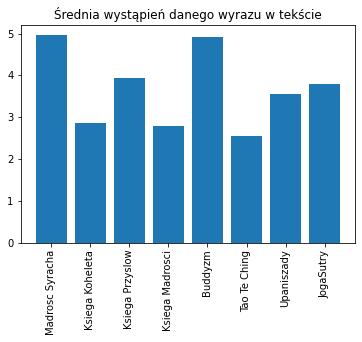

In [0]:
def plot_bar(data1, data2, title):
  plt.bar(data1, data2)
  plt.xticks(rotation = 90)
  plt.title(title)
  plt.show()

plot_bar(translations, np.sum(grouped_data, axis = 1)/np.sum(grouped_data>0, axis = 1), 'Średnia wystąpień danego wyrazu w tekście')

Największą średnią liczbę wystąpień wyrazów możemy zauważyć w Mądrościach Syracha oraz w Buddyźmie.

Natomiast księgi o wartościach wystąpień poniżej trzech są najkrótszymi księgami z podanych.

## Średnia długość słów w księdze

In [0]:
WordsLen = []
for col in grouped_data.columns:
  WordsLen.append(len(col))

In [0]:
A = []
j = 0
for word in grouped_data.values:
  i = 0
  length = 0
  for x in word:
    length = length + x*WordsLen[i] # liczba wystąpień słowa razy długość słowa
    i = i+1
  A.append(length / data_len_words.values[j][0])
  j = j+1

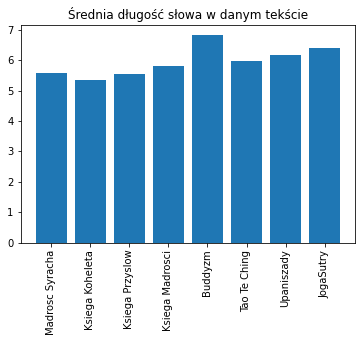

In [0]:
plt.bar(translations, A)
plt.xticks(rotation = 90)
plt.title('Średnia długość słowa w danym tekście')
plt.show()

Średnia długość słów w księdze jest do siebie zbliżona dla wszystkich słów. Ciekawiej pewnie byłoby zająć się średnią długością zdań.

## Podobieństwa ksiąg

#### Opis metodologii:
Dla każdej z ksiąg możemy bez problemu zdobyć wektor liczności wystąpień poszczególnych słów. Dla każdej pary ksiąg można zatem obliczyć odległość euklidesową biorąc za współrzędne te właśnie liczności i porównać obliczone wartości dla różnych par.<br>Update: powyższa metoda jest wrażliwa na liczbę słów występujących w poszczególnych księgach, co nie powinno mieć miejsca. Celem zapobiegnięcia takiej czułości, znormalizujemy liczbę poszczególnych słów w księdze. Takie działanie ma sens, gdy porównujemy księgi o podobnym rzędzie liczby wyrazów. Dla poszczególnych tekstów, gdzie słów jest kilkadziesiąt, osiągane wyniki byłyby wyższe.


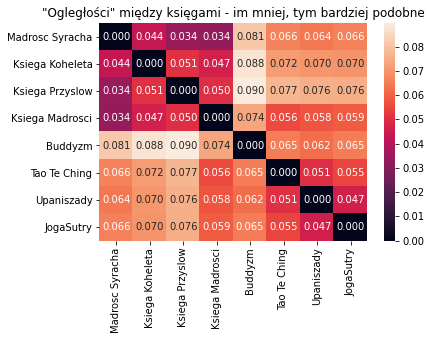

In [0]:
def distance_plot(labels, df, ret_max = False, vmax = None):
    data = df/(df.sum(axis = 1)[:, None])
    A = [[0]*len(labels) for _ in range(len(labels))]
    maxdist = 0
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            x = data.iloc[i,:]
            y = data.iloc[j,:]
            dist = math.sqrt(np.sum((x-y)**2))
            A[i][j] = dist
            A[j][i] = dist
            if dist > maxdist: maxdist = dist
    if ret_max: return maxdist
    sns.heatmap(A, annot = True, fmt = '.3f', vmax = vmax, xticklabels = labels, yticklabels=labels).set_title('"Ogległości" między księgami - im mniej, tym bardziej podobne')
    plt.show()
distance_plot(translations, grouped_data)

Jeśli metodologia jest właściwa to najbardziej podobnymi księgami okazują się Księga Przysłów i Mądrość Syracha oraz Księga Mądrości i Mądrość Syracha. Podobne są też do siebie księgi biblijne po prostu.

Oczywiście korzystamy tylko z części słów występujących w księgach.

## Lematyzacja

Na razie nie będziemy jej stosować, być może wrócimy z tym przy inżynierii cech.

Przypominając, wykorzystalismy lematyzację przy słowach występujących dla wszystkich ksiąg. Nie mamy pewności czy zamienione zostały wszystkie słowa.

Tutaj sprawdzimy, o ile słów zmniejszy się ramka danych po lematyzacji.

In [0]:
words_list = np.array(grouped_data.columns)
words_after_lem = lemmatization(words_list)

In [0]:
print("Liczba słów po zabiegu lematyzacji: ", len(words_after_lem.tolist()))
print("Liczba słów w niezmienionej ramce danych: ", len(grouped_data.columns))

Liczba słów po zabiegu lematyzacji:  6032
Liczba słów w niezmienionej ramce danych:  8266


Jak widzimy, po sprowadzeniu słów do podstawowej formy straciliśmy ponad 2 tys. słów z danych. W inżynierii cech może być ciekawe połączenie tych kolumn o tych samych słowach a innych formach w jedną i na tym przeprowadzenie klasteryzacji w celu porównania.

## Analiza sentymentu

Sprawdzimy czy księgi ogólnie są bardziej pozytywne, negatywne czy może neutralne. 

Dobrym podejściem jest wytrenowanie modelu oceniającego sentyment a potem przetestowanie go do danych, w naszym przypadku nie możemy tak zrobić, więc zastosujemy drugie, dużo prostrze podejście - mianowicie policzymy sentyment dla każdego słowa, potem zliczymy liczby wystąpień tych słów, liczba których wartości będzie większa określi nasz sentyment.

Jest to słabe podejście, ale przynajmniej warto je przetestować.

In [0]:
columns_names = data.columns.tolist()
columns_names.pop(0) # pozbywamy się kolumny z nazwami ksiąg
columns_sentiment = []
for i in columns_names:
  text = i
  blob = TextBlob(text)
  sentiment = blob.sentiment.polarity
  if sentiment == 0.0:
    sentiment = "neutral"
  elif sentiment > 0:
    sentiment = "positive"
  else:
    sentiment = "negative"
  columns_sentiment.append(sentiment)

In [0]:
def sentiment(data):
  books_sentiment = []
  for row in data.values:
    i = 0
    pos, neu, neg = 0,0,0
    # zliczamy liczby sentymentów
    for x in row:
      if columns_sentiment[i] == "positive":
        pos = pos + x
      elif columns_sentiment[i] == "negative":
        neg = neg + x
      else:
        neu = neu + x
      i = i + 1
    # wynik dla wiersza
    if pos >= neg:
      if pos < neu or pos == neg:
        books_sentiment.append("neutral")
      else:
        books_sentiment.append("positive")
    else:
      if neg < neu:
        books_sentiment.append("neutral")
      else:
        books_sentiment.append("negative")
  return books_sentiment

In [0]:
sentiment(grouped_data)

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral']

Jak się okazuje najwięcej jest słów neutralnych w każdej z ksiąg. Oczywiście, jest to naiwna metoda i trzeba o tym pamiętać, biorąc pod uwagę te wyniki.


## Wróćmy do niepogrupowanych rozdziałów

### Ile rozdziałów ma dana księga?

In [0]:
all_rows_books = data.label.to_list()
CH_sum = Counter(all_rows_books)

In [0]:
data_CH_sum = pd.DataFrame.from_dict(CH_sum, orient='index').reset_index()
data_CH_sum.rename(columns={'index': 'Księga', 0:'Rozdziały'}, inplace=True)

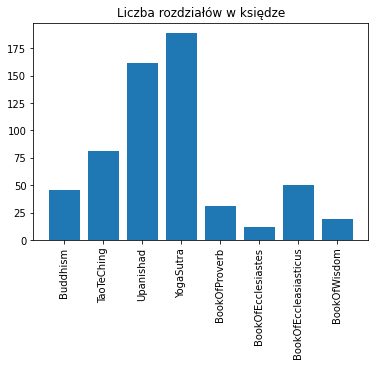

In [0]:
plot_bar(data_CH_sum['Księga'], data_CH_sum['Rozdziały'], 'Liczba rozdziałów w księdze')

YogaSutra jest drugą największą księgą i ma najwięcej rozdziałów. Natomiast najdłuższa jest BookOfEccleasiasticus, a ma "tylko" 50 rozdziałów, więc prawdopodobnie to jej rozdziały są najdłuższe.

### W jakich księgach są najdłuższe rozdziały?

In [0]:
CH_sum = pd.DataFrame(np.sum(data, axis = 1), columns = ['Liczba słów w rozdziałach ksiąg:'])
sorted_CH_sum = pd.concat([data['Unnamed: 0'], CH_sum], axis=1).sort_values(by=['Liczba słów w rozdziałach ksiąg:'], ascending=False)
sorted_CH_sum.head(10)

,Unnamed: 0,Liczba słów w rozdziałach ksiąg:
36,Buddhism_Ch37,1194
567,BookOfEccleasiasticus_Ch47,557
41,Buddhism_Ch42,522
543,BookOfEccleasiasticus_Ch23,414
544,BookOfEccleasiasticus_Ch24,400
558,BookOfEccleasiasticus_Ch38,390
527,BookOfEccleasiasticus_Ch7,387
586,BookOfWisdom_Ch16,378
526,BookOfEccleasiasticus_Ch6,376
582,BookOfWisdom_Ch12,373


Najdłuższy jest rozdział należy do księgi Buddyzmu, jednak jak zakładalismy to właśnie BookOfEccleasiasticus, czyli Mądrość Syracha ma najdłusze rozdziały (6 z 10 wyświetlonych).

Przyjrzyjmy się jakie są najkrótsze rozdziały.

In [0]:
sorted_CH_sum.sort_values(by=['Liczba słów w rozdziałach ksiąg:']).head(10)

,Unnamed: 0,Liczba słów w rozdziałach ksiąg:
13,Buddhism_Ch14,0
269,Upanishad_Ch143,6
251,Upanishad_Ch125,7
229,Upanishad_Ch103,7
19,Buddhism_Ch20,8
274,Upanishad_Ch148,8
254,Upanishad_Ch128,8
270,Upanishad_Ch144,9
132,Upanishad_Ch6,9
253,Upanishad_Ch127,9


Najkrótsze są rozdziały Upaniszady. 

Ciekawostka - spośród wybranych słów przez twórców ramki, rozdział 14 Buddyzmu nie zawiera żadnego.

### Analiza sentymentu dla rozdziałów ksiąg

In [0]:
CH_data = data.drop(['Unnamed: 0', 'label'], axis = 1)
CH_sent = sentiment(CH_data)

In [0]:
Counter(CH_sent)

Counter({'neutral': 590})

W tym przypadku też, żaden rozdział nie okazał się inny niż o neutralnym sentymencie.

## Podsumowanie

Kilka przykładowych wniosków, które mogą przydać się później:
- po lematyzacji liczba słów zmniejsza się o ok. 2tys.
- analiza sentymentu wykazała, że większość słów jest neutralna
- najwięcej rozdziałów ma księga o hinduiźmie
- najdłuższe rozdziały są w Mądrościach Syracha
- ponad 50% słów jest unikatowane dla danej księgi, tylko 1.29% występuje w każdej z nich
- jeden rozdział Buddyzmu jest pusty


